In [ ]:
from langchain_openai import ChatOpenAI
import os

# if "OPENAI_API_KEY" not in os.environ:
os.environ["OPENAI_API_KEY"] = (
    "your-api-key"
)

llm = ChatOpenAI(model="gpt-4o-mini")

In [13]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain

# LangGraph의 구조와 그래프 시각화
LangGraph는 LLM 기반의 Agent 및 RAG 파이프라인을 위한 그래프 구조 설계 및 실행 기능을 제공하는 라이브러리입니다. 이 문서에서는 LangGraph의 주요 개념과 사용법을 설명합니다.

### 1. LangGraph로 간단한 챗봇 구현에서는

- Agent를 구성하는 state, tools, nodes, edges, compile 등을 배웁니다.

### 2. Agent의 그래프 시각화에서는

- Agent의 workflow를 시각화 하여 표현합니다. 현재 작동 방식을 직관적으로 살피는데 큰 도움이 됩니다.

---

## 1. LangGraph로 간단한 챗봇 구현

LangChain으로 구현된 간단한 챗봇을 LangGraph로 구현합니다. LangGraph의 주요 구성 요소는 아래와 같습니다.

### StateGraph
StateGraph는 LangGraph의 중심적인 개념으로, Agent나 RAG의 작업 흐름 전체를 담당하는 객체입니다. 이는 여러 노드와 엣지를 연결하여 데이터가 흐르는 방향과 처리 과정을 정의합니다. 더 나아가 복잡한 의사결정 과정을 단계별로 구조화하여, 사고(Reasoning)부터 행동(Action), 그리고 관찰(Observation)까지의 사이클을 정의합니다.
- Agent가 사용할 상태(State)의 타입을 정의
- 노드(Node)들의 집합을 관리
- 엣지(Edge)를 통해 노드 간 연결과 데이터 흐름을 정의
- 워크플로우를 컴파일하여 실행 가능한 그래프로 변환
  
### State
State는 그래프 내에서 노드 간에 전달되는 데이터 구조를 정의합니다. State는 그래프의 노드가 실행될 때마다 상태를 업데이트하고 다음 노드에 전달합니다.
- `TypedDict`를 사용하여 데이터 타입을 명시적으로 정의함
- 메시지, 도구 호출 결과, 중간 계산값 등을 포함
- add_messages와 같은 함수를 통해 데이터가 어떻게 업데이트될지 정의
- 그래프 실행 시 노드 간 데이터 일관성을 유지하는 역할

### Node
Node는 그래프 내에서 실제 작업을 수행하는 함수 단위입니다. 노드는 그래프의 두뇌 역할을 하며, 각 노드는 특정 기능을 담당하고 상태를 변형합니다.
- 하나의 동작 단위(예: 검색, 생성, 분류 등)를 담당
- State를 입력으로 받아 처리 후 업데이트된 State를 반환
- LLM 호출, 도구 사용, 외부 API 요청 등 다양한 작업을 수행
- ToolNode와 같은 특수 노드는 Agent가 사용할 수 있는 도구를 정의하고 이를 실행하는 기능 제공

### Edge
Edge는 노드 간의 연결을 정의하며, 데이터 흐름의 방향과 조건을 결정합니다. START에서 시작해서 END로 도달하는 노드 간의 다양한 경로를 정의합니다.
- 노드 간 상호작용 방식과 흐름의 논리를 담당
- 기본 Edge: 한 노드에서 다른 노드로의 단순 연결
- Conditional Edge: 조건부 연결로, 노드 실행 결과에 따라 다음 노드를 결정


이번 실습에서는 LangGraph로 RAG 아키텍처를 구현해봅니다.

## 2. State

Graph 내에서 유통될 State(데이터)를 정의합니다. `TypedDict`는 Python에서 타입 힌팅을 지원하며, 데이터 구조의 형태를 명시적으로 정의할 수 있게 합니다. `add_messages` 함수는 state의 `messages` 필드가 업데이트될 때 기존 메시지에 새 메시지를 추가하는 방식을 명시합니다.

In [14]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

In [15]:
class AgentState(TypedDict):
    # add_messages 함수는 업데이트 처리 방식을 정의합니다
    # 기본값은 대체(replace)이지만, add_messages는 "추가(append)"를 의미합니다
    messages: Annotated[str, add_messages]

여기서는 `messages`라는 하나의 필드만 포함하지만,실제 애플리케이션에서는 다양한 데이터를 포함할 수 있습니다.

## 3. VectorDB 정의하기

Langchain 기반 RAG 방식과 유사하게 Chroma vectorDB를 생성합니다.

In [16]:
loader = PyPDFLoader("Maximizing Muscle Hypertrophy.pdf")
pages = loader.load_and_split()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(pages)

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings(model="text-embedding-3-small"))
retriever = vectorstore.as_retriever()

## 4. Node

아래는 그래프에서 데이터를 처리하는 부분으로, 함수를 활용하여 만들 수 있습니다. RAG 파이프라인의 역할을 수행하는 `generate_answer` 함수를 선언하고, 이를 노드로 변환하는 작업은 5. 그래프 구성에서 진행됩니다.

In [17]:
def generate_answer(state):

    print("---GENERATE ANSWER FROM RAG---")

    messages = state["messages"]  # 그래프를 통해 전달되는 데이터
    query = messages[-1].content  # user query

    system_prompt = """당신은 질문-답변을 담당하는 전문가 입니다. 다음 정보를 활용하여 질문에 답을 하시오. 
        모르면 모른다고 답하고, 답변은 간결하게 하시오.
        {context}"""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )

    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    rag_chain = create_retrieval_chain(retriever, question_answer_chain)

    print("Input query for RAG: ", query)

    response = rag_chain.invoke({"input": query})
    print(response)

    return {"messages": [response["answer"]]}

## 5. 그래프 구성
그래프의 뼈대인 StateGraph를 먼저 정의해 줍니다. AgentState 타입을 사용하여 StateGraph를 초기화하고, RAG 노드를 추가합니다.

In [18]:
from langgraph.graph import END, StateGraph, START

# Graph 정의
workflow = StateGraph(AgentState)

# 노드 생성
workflow.add_node("rag", generate_answer)  # 답변 생성

그래프의 노드 간 간선(Edge)을 정의하고 그래프를 컴파일합니다. START → "rag" → END의 단순한 선형 흐름을 가지며, 사용자의 질문이 "rag" 노드를 통해 처리된 후 결과가 반환됩니다. 더 복잡한 그래프에서는 조건부 간선(Conditional Edge)를 사용하여 상태나 결과에 따라 다른 노드로 분기할 수 있습니다.

In [19]:
workflow.add_edge(START, "rag")

workflow.add_edge("rag", END)

# compile하여 그래프의 아키텍쳐를 고정
graph = workflow.compile()

LangGraph는 그래프의 구조를 시각화하여 워크플로우의 구조를 이해하는 데 도울 수 있는 기능을 제공합니다. 

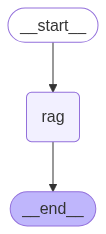

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))  # xray=True 옵션으로 그래프의 내부 구조까지 표시
except Exception:
    # This requires some extra dependencies and is optional
    pass

그래프에 입력할 쿼리를 정의합니다. 입력 형식은 앞서 정의한 AgentState 타입과 일치해야 합니다. 여기서는 state를 `messages: Annotated[str, add_messages]`와 같이 정의하였기 때문에, 포맷에 맞는 형태로 인풋을 제공해 줍니다. 이 입력은 그래프의 초기 상태가 되어 START 노드에서부터 흐름이 시작됩니다.

In [21]:
inputs = {"messages": ["이 글의 주제는 뭐야?"]}

Langchain과 마찬가지로 `invoke` 메서드로 그래프를 실행합니다.

In [22]:
output = graph.invoke(inputs)

---GENERATE ANSWER FROM RAG---
Input query for RAG:  이 글의 주제는 뭐야?
{'input': '이 글의 주제는 뭐야?', 'context': [Document(id='bbf165b4-ecbd-4bca-a9ec-7e96f60e5720', metadata={'creator': 'PyPDF', 'total_pages': 14, 'page': 13, 'creationdate': '2019-12-06T03:19:50+01:00', 'producer': 'iText® 7.1.1 ©2000-2018 iText Group NV (AGPL-version)', 'source': 'Maximizing Muscle Hypertrophy.pdf', 'moddate': '2019-12-06T03:19:50+01:00', 'page_label': '14'}, page_content='© 2019 by the authors. Licensee MDPI, Basel, Switzerland. This article is an open access\narticle distributed under the terms and conditions of the Creative Commons Attribution\n(CC BY) license (http://creativecommons.org/licenses/by/4.0/).'), Document(id='204f1410-9d6c-4efb-997d-06fe19d5d4cd', metadata={'page': 13, 'page_label': '14', 'creationdate': '2019-12-06T03:19:50+01:00', 'source': 'Maximizing Muscle Hypertrophy.pdf', 'producer': 'iText® 7.1.1 ©2000-2018 iText Group NV (AGPL-version)', 'total_pages': 14, 'creator': 'PyPDF', 'moddate'

In [23]:
print(output["messages"][-1].content)

이 글의 주제는 근육 섬유 단면적과 근력 증가의 상관관계 및 저항 훈련 프로그램에 대한 연구입니다.


## 6. 조건부 간선과 Router LLM을 활용한 향상된 RAG 시스템

이번에는 LangGraph의 조건부 간선(Conditional Edge)과 Router LLM을 활용하여 더 지능적인 시스템을 구현해보겠습니다. 이 시스템은 질문의 특성에 따라 일반 LLM을 사용할지, RAG를 통해 답변할지 자동으로 결정합니다.

In [24]:
from typing import Annotated, TypedDict, Literal
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
import os

In [25]:
# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # 메시지 이력
    datasource: str  # 라우팅 결정: 'rag' 또는 'llm'

### 라우터 LLM (Router LLM)
라우터 LLM은 사용자의 질문을 분석하여 어떤 처리 경로로 라우팅할지 결정하는 역할을 합니다. 일반적인 LLM을 구조화된 출력을 생성하도록 변형하여 사용합니다. 여기서 라우터 LLM의 출력값은 대부분의 경우 `"rag"`와 `"llm"` 둘 중 하나로 제한됩니다. 거의 성공하지만, 가끔 실패할 가능성도 있습니다.

In [26]:
# 라우팅을 위한 구조화된 출력 클래스 정의
class RouteQuery(BaseModel):
    """
    사용자 질문을 가장 적절한 경로로 라우팅합니다.
    """

    datasource: Literal["rag", "llm"] = Field(
        ...,
        description="사용자 질문이 운동/근육 관련이면 'rag'로, 그렇지 않으면 'llm'으로 라우팅합니다.",
    )


# 라우터 LLM 설정
structured_llm_router = llm.with_structured_output(RouteQuery)

여기서 `RouteQuery` 클래스는 Pydantic 모델로, 라우팅 결정을 위한 구조를 정의합니다. `datasource` 필드는 'rag' 또는 'llm' 중 하나의 값만 가질 수 있도록 Literal 타입으로 제한하고 있습니다.  

`with_structured_output` 메서드는 LLM이 자유 형식의 텍스트가 아닌 정의된 구조의 객체를 반환하도록 형식 강요(Format enforcing)를 설정합니다. 이 과정에서 `Pydantic`의 `BaseModel`을 상속한 `RouteQuery` 클래스가 사용되며, 이를 통해 LLM의 출력값이 `datasource` 필드를 반드시 포함하고, 그 값이 `"rag"` 또는 `"llm"` 중 하나로 제한되도록 강제되는 과정입니다. 

이러한 형식 강요 덕분에 개발자는 복잡한 문자열 파싱 없이도 `datasource` 필드를 통해 라우팅 정보를 손쉽게 추출할 수 있습니다. 다만, 구조화된 출력 덕분에 후속 처리를 단순화할 수 있는 것이지, 출력 결과가 항상 동일하거나 일관된 라우팅 경로로만 이어진다는 의미는 아닙니다.

### 라우터 프롬프트 설정
라우터 LLM이 정확한 결정을 내릴 수 있도록 명확한 지침을 제공하는 프롬프트를 설정합니다.

In [27]:
# 라우터 프롬프트 설정
router_system = """
당신은 사용자 질문을 적절한 응답 모델로 라우팅하는 전문가입니다.
이 시스템은 다음 두 가지 모델을 가지고 있습니다:

RAG: 운동, 근육 발달, 근육 비대화, 피트니스, 체력 관련 질문에 전문화되어 있습니다.
LLM: 그 외 모든 질문을 처리합니다.

사용자의 질문이 운동, 근육, 체력, 피트니스와 관련되어 있으면 'rag'로 라우팅하고,
그렇지 않으면 'llm'으로 라우팅하세요.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

이 프롬프트는 라우터 LLM에게 정확한 결정 기준을 제공합니다. 특히 운동 및 근육 관련 질문을 RAG 모델로, 그 외 질문을 일반 LLM으로 라우팅하도록 명시하고 있습니다.

### 라우팅 노드 구현
라우팅 결정을 내리는 함수를 구현합니다. 이 함수는 사용자 질문을 분석하고 라우터 LLM에 전달하여 라우팅 결정을 얻습니다.

In [28]:
# 라우팅 노드 - 사용자 질문을 분석하여 라우팅 결정
def route_question(state):
    """사용자 질문을 분석하여 RAG 또는 LLM으로 라우팅 결정"""
    messages = state["messages"]

    # 가장 최근 사용자 메시지 추출
    last_message = messages[-1]
    if hasattr(last_message, "content"):
        question = last_message.content
    else:
        question = last_message[1] if isinstance(last_message, tuple) else str(last_message)

    print(f"라우팅 중: '{question}'")

    # 라우팅 결정
    result = question_router.invoke({"question": question})
    route = result.datasource

    print(f"라우팅 결정: {route}")

    return {"messages": messages, "datasource": route}

### 조건부 간선 (Conditional Edges)
조건부 간선은 노드 실행 결과에 따라 다음 노드를 동적으로 결정하는 메커니즘입니다. 이는 그래프의 흐름을 상태에 따라 달라지게 만들 수 있습니다.

In [29]:
# 조건부 엣지 함수 - 라우팅 결정에 따라 다음 노드 선택
def route_based_on_datasource(state):
    """라우팅 결정에 따라 다음 노드를 선택"""
    return state["datasource"]

이 함수는 상태의 `datasource` 필드 값(`'rag'` 또는 `'llm'`)을 반환하여 다음에 실행할 노드를 결정합니다.

### 그래프 구조와 조건부 간선 설정
이제 노드와 그래프 구조를 정의하고 조건부 간선을 설정합니다.

In [30]:
# RAG 노드 - 검색 기반 응답 생성
def rag_answer(state):
    """벡터 저장소에서 관련 문서를 검색하여 응답 생성"""
    messages = state["messages"]

    # 가장 최근 사용자 메시지 추출
    last_message = messages[-1]
    if hasattr(last_message, "content"):
        query = last_message.content
    else:
        query = last_message[1] if isinstance(last_message, tuple) else str(last_message)

    print(f"RAG 모델 응답 생성 중: '{query}'")

    # RAG 파이프라인 구성
    system_prompt = """당신은 운동과 근육 발달에 관한 전문가입니다. 
    다음 정보를 활용하여 질문에 사실에 기반한 정확한 답변을 제공하세요.
    모르는 내용이나 제공된 정보에 없는 내용은 추측하지 말고 모른다고 답변하세요.
    {context}"""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )

    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    rag_chain = create_retrieval_chain(retriever, question_answer_chain)

    # 응답 생성
    response = rag_chain.invoke({"input": query})
    answer = response["answer"]

    print(f"RAG 응답: {answer[:100]}...")

    return {"messages": [HumanMessage(content=answer)], "datasource": state["datasource"]}

In [31]:
# LLM 노드 - 일반 대화용 응답 생성
def llm_answer(state):
    """일반 LLM을 사용하여 응답 생성"""
    messages = state["messages"]

    # 가장 최근 사용자 메시지 추출
    last_message = messages[-1]
    if hasattr(last_message, "content"):
        query = last_message.content
    else:
        query = last_message[1] if isinstance(last_message, tuple) else str(last_message)

    print(f"일반 LLM 응답 생성 중: '{query}'")

    # 시스템 메시지 추가
    system_message = """당신은 친절하고 지식이 풍부한 AI 비서입니다. 
    사용자의 질문에 정확하고 도움이 되는 답변을 제공하세요."""

    # 응답 생성
    response = llm.invoke([("system", system_message), ("human", query)])

    print(f"LLM 응답: {response.content[:100]}...")

    return {"messages": [HumanMessage(content=response.content)], "datasource": state["datasource"]}

In [32]:
# 그래프 구조 정의
workflow = StateGraph(AgentState)

# 노드 추가
workflow.add_node("router", route_question)  # 라우팅 노드
workflow.add_node("rag", rag_answer)  # RAG 노드
workflow.add_node("llm", llm_answer)  # LLM 노드

# 엣지 추가
workflow.add_edge(START, "router")  # 시작 → 라우터
workflow.add_conditional_edges(  # 라우터 → RAG 또는 LLM
    "router", route_based_on_datasource, {"rag": "rag", "llm": "llm"}  # 운동/근육 관련 → RAG  # 기타 → LLM
)
workflow.add_edge("rag", END)  # RAG → 종료
workflow.add_edge("llm", END)  # LLM → 종료

# 그래프 컴파일
graph = workflow.compile()

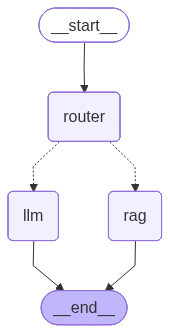

In [33]:
# 그래프 시각화
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    print("그래프 시각화에 필요한 의존성이 부족합니다.")

In [34]:
# 그래프 실행 함수
def ask(question):
    """질문을 입력받아 그래프를 실행하고 결과 반환"""
    input_data = {"messages": [HumanMessage(content=question)], "datasource": ""}  # 초기값은 비워둠

    result = graph.invoke(input_data)

    return result["messages"][-1].content

테스트 쿼리를 바탕으로 결과를 확인합니다.

In [35]:
# 테스트 1
question1 = "근육 발달을 위한 최적의 단백질 섭취량은 얼마인가요?"
print(f"\n질문: {question1}")
print(f"답변: {ask(question1)}")


질문: 근육 발달을 위한 최적의 단백질 섭취량은 얼마인가요?
라우팅 중: '근육 발달을 위한 최적의 단백질 섭취량은 얼마인가요?'
라우팅 결정: rag
RAG 모델 응답 생성 중: '근육 발달을 위한 최적의 단백질 섭취량은 얼마인가요?'
RAG 응답: 제공된 정보에는 근육 발달을 위한 최적의 단백질 섭취량에 대한 구체적인 수치나 권장량이 포함되어 있지 않습니다. 따라서 이 질문에 대해 정확한 답변을 제공할 수 없습니다....
답변: 제공된 정보에는 근육 발달을 위한 최적의 단백질 섭취량에 대한 구체적인 수치나 권장량이 포함되어 있지 않습니다. 따라서 이 질문에 대해 정확한 답변을 제공할 수 없습니다.


In [36]:
# 테스트 2
question2 = "파리의 에펠탑은 언제 지어졌나요?"
print(f"\n질문: {question2}")
print(f"답변: {ask(question2)}")


질문: 파리의 에펠탑은 언제 지어졌나요?
라우팅 중: '파리의 에펠탑은 언제 지어졌나요?'
라우팅 결정: llm
일반 LLM 응답 생성 중: '파리의 에펠탑은 언제 지어졌나요?'
LLM 응답: 에펠탑은 1887년부터 1889년까지 건설되었습니다. 1889년에 파리에서 열린 만국 박람회를 기념하기 위해 세워졌으며, 당시에는 세계에서 가장 높은 구조물이었습니다. 에펠탑은 현...
답변: 에펠탑은 1887년부터 1889년까지 건설되었습니다. 1889년에 파리에서 열린 만국 박람회를 기념하기 위해 세워졌으며, 당시에는 세계에서 가장 높은 구조물이었습니다. 에펠탑은 현재 파리의 상징적인 랜드마크 중 하나로 널리 알려져 있습니다.


조건부 간선을 통해 사용자 질문의 내용에 따라 서로 다른 처리 경로를 동적으로 선택할 수 있습니다. 이러한 구조는 다양한 종류의 질문을 처리해야 하는 복잡한 대화 시스템에서 특히 유용합니다. 질문의 특성에 따라 가장 적합한 응답 생성 방식을 선택하여 전체적인 사용자 경험을 향상시킬 수 있습니다.